 # Projeto Programação e Algoritmia

## Indice
1.  Introdução
2.  Objetivos
3.  Metodologia
4.  Dados e pre-processamento
5.  Processamento, analise e discussão dos resultados
6. Desenvolvimento de um sistema de recomendação de receitas por meio de ML
7.  Conclusão e notas finais


## Introdução

Comforme a populaão mundial cresce e vista a limitação dos recurso desponiveis no planeta, 
surge a necessidade de desenvolver uma solução que possa dar conta do crescimento mundial dadas as limitações.
Tal solução passa por desenvolver uma dieta equilibrada e sustentavel e disponibiliza-la a população de forma intuitiva e de facil uso, 
portanto, é precso desenvolver uma ferramenta que possa juntar ambos e este é o foco deste trabalho, estudar a constituição alimentar 
das dietas de diversos paises e desenvolver uma ferramenta que possa recomendar uma receita balanceada baseado na dieta da EAT-Lancet.
A comissão EAT-Lancet procura responder a pergunta "Podemos alimentar uma população futura de 10 bilhões de pessoas com uma dieta saudável 
dentro dos limites planetários?",então procura desenvolver uma dieta que visa disponibilizar o nivel de nutrição adequado para um ser humano medio.

A Organização Mundial da Saúde recomenda:

50-55% carboidratos
30-35% lipídios ou gorduras
12-15% de proteína 


## Objetivos
O seguinte trabalho visa estudar a composição alimentar de dietas de certos paises, compara-la ao modelo de dieta EAT-Lancet e a composição nutricional de uma lista de receitas do site Food.com, assim como, baseando-se nestes dados, desenvolver um sistema de aprendizagem de maquina capaz de recomendar receitas saudaveis. E para esse fim, sera imprescindivel responder as seguintes questões:


1 - Qual a composição duma dieta me portugal, e em egito, EUA , china e Brasil, e quao diferentes estes sao entre si e entre a EAT-Lancet

2 - Qual a composição de produtos animais nas dietas dos paises citados e a EAT-Lancet?

3 - como se viu a evolução da composição das dietas dos paises citados ao longo dos anos

4 - Existe alguma relação entre a avaliação duma receita e o tamanho das avalições? e o numero de estapas? e o numero de ingridientes? e o tempo de demora?

5 - como se distribuem as receitas filtradas por EAT-Lancet por categoria? Qual categoria possui melhores avaliações?


    perguntas extra ( não tenho certeza se irei incluir ao longo do trabalho):
6 - Quais os produtos mais consumidos em paises e qual a relação com a coltura do pais?

7 - existe alguma diferença notavel de  proporção entre ingredientes de origem animal e os de origem nao animal?

8 - o tempo de preparação da receita influencia de alguma forma o nivel nucticional da receita?

9 - como varia a pegada de carbono das dietas dos diferentes paises ao longo do tempo?

## Metodologia

    Tecnologias usadas na elaboração deste trabalho:

    Linguagens de programação: Python;
        Bibliotecas: Seaborn, Matplotlib, numpy, plotly, warning, pandas, sklearn...
        Classes: 
    Softwares: Jupyter (atraves de uma extensão do visual studio code);
    Formatos de ficheiro de dados: csv,parquet(ou feather) e excel (xls);
    Plataforma de hospedagem : github




## Dados e pre-processamento
Como ao longo do trabalho sera necessario comunicar dados entre ficheiros e certas informações ou são irrelevantes ou repetidas, irei tratar de preparar os data frames principais para cada pergunta nesta secssão, assim otimiza-se o processamento em si que vem a seguir e evita-se cria um grande dataframe com dados desnecessarios.

esta secssao tera 3 partes:
1. Preparação do ambiente de trabalho
2. leitura e armazenamento dos dados, otimização e adequação dos tipos de dados
3. pre-Filtragem



###  Preparação do ambiente de trabalho

In [137]:
import os
import pandas as pd
import chart_studio 
import chart_studio.plotly as py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import plotly.express  as px
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

chart_studio.tools.set_credentials_file(username='Mohaamedl', api_key='MvUpzt7O9SQLxrTEuefC')

pd.options.plotting.backend = 'plotly'


# paths dos ficheiros


# filename_diet_animal = '../data/eat-lancet-diet-animal-products.csv' desnecessario visto q esses dados estão ja noutro ficheiro
filename_diet_composition = '../data/eat-lancet-diet-comparison (2).csv'
filename_food_emission = '../data/food-emissions-supply-chain (1).csv'
filename_recipes_raw = 'C:/Users/moham/Documents/data_compressed/RAW_recipes.csv' #! Atenção, deve alterar o caminho para "../data/nome do ficheiro" , usei ficheiros no pc pq nao cabem no github, mas estarei a inclui-los no envio final
filename_reviews_raw= 'C:/Users/moham/Documents/data_compressed/RAW_interactions.csv'
filename_recipes_parq = '../data/recipes.parquet'
filename_reviews_parq = '../data/reviews.parquet'



# funções 

# Leitura
def read_diet_and_emission(filename,cols_not_use=[]):
    cols = list(pd.read_csv(filename,nrows=1))
    df = pd.read_csv(filename,usecols=list(col for col in cols if  col not in cols_not_use),
                     dtype={'Entity':'category','Code':'category','Year':'int16'})
    df['Total'] = df.sum(axis=1)
    
    datatypes = dict.fromkeys(df.select_dtypes(np.float64).columns, np.float16) # reduzir o numero de bits dos float
    df = df.astype(datatypes)
    
    df2 = pd.read_csv(filename) # descomentar para saber quao otimizado ficou
    print(f' De {df2.memory_usage().sum()/1000} Kbytes para {df.memory_usage().sum()/1000} Kbytes, uma redução de {(df2.memory_usage().sum()/1000)/(df.memory_usage().sum()/1000)*100:.2f} % ')
    return df


def read_recipes_csv(filename,cols_not_use=[]):
    cols = list(pd.read_csv(filename,nrows=1))
    df = pd.read_csv(filename,usecols=list(col for col in cols if  col not in cols_not_use),
                     dtype={'id':'int32','minutes':'int32','contributor_id':'int32','n_steps':'int8','n_ingredients':'int8'},
                     parse_dates=['submitted'])
    # adicionar os nutrientes divididos por colunas, para facilitar 
    nutricao_list = ['calorias','gordura_total(PVD)','açucar(PVD)','sodio(PVD)','proteina(PVD)','gordura_sat(PVD)','carboidratos(PVD)']
    # O valor diário percentual (PVD) mostra o quanto um nutriente em uma porção de alimento contribui para uma dieta diária total.
    df[nutricao_list] = df.nutrition.str.replace('[','').str.replace(']','').str.split(',',expand=True)
    df[nutricao_list] = df[nutricao_list].astype('float16')
    df.pop('nutrition')
    df2 = pd.read_csv(filename) # descomentar para saber quao otimizado ficou
    print(f' De {df2.memory_usage().sum()/1000} Kbytes para {df.memory_usage().sum()/1000} Kbytes, uma redução de {(df2.memory_usage().sum()/1000)/(df.memory_usage().sum()/1000)*100:.2f} % ')
    return df



def read_reviews_csv(filename,cols_not_use=[]):
    cols = list(pd.read_csv(filename,nrows=1))
    df = pd.read_csv(filename,usecols=list(col for col in cols if  col not in cols_not_use),
                     dtype={'user_id':'int32','recipe_id':'int32','rating':'int8'},
                     parse_dates=['date'])
    df['tam_aval'] = df.review.str.len()
    df['tam_aval'] = df['tam_aval'].fillna(0).astype('int16')
    df.pop('review')
    df2 = pd.read_csv(filename) # descomentar para saber quao otimizado ficou
    print(f' De {df2.memory_usage().sum()/1000} Kbytes para {df.memory_usage().sum()/1000} Kbytes, uma redução de {(df2.memory_usage().sum()/1000)/(df.memory_usage().sum()/1000)*100:.2f} % ')
    return df

# Plots

def barPlot_diet(df,year,countries=['Portugal']):
    df = df[(df['País'].isin(countries) ) & (df['Ano']==year)] # filtrar os dados por ano e paises
    df1 = pd.melt(df, 
        id_vars='País', 
        value_vars=list(df.columns[3:-1]),
        var_name='Tipo', 
        value_name='Consumo(g)'
        ) # converte numa dataframe mais legivel para px, é como um pd.pivot reverso 
    #plot 
    fig = px.bar(df1,x='Consumo(g)',
                width=1200,
                height=500,
                y='País',
                color='Tipo',
                text='Tipo',
                barmode='relative',
                title='Composisão de dieta por pais dividida por tipo de alimento',
                color_discrete_map={
                    'cereais':'#c79c28',
                    'legumes':'#007d2e',
                    "raízes_tubérculos":'#37ed79',
                    "frutos":'#e5ed4e',
                    "lacticínios":'#0786a3',
                    "carne_vermelha":'#962323',
                    "aves":'#fa8989',
                    "ovos":'#d7f595',
                    "marisco":'#95bff5',
                    "leguminosas":'#95f5cb',
                    "frutos_de_casca_rija":'#634135',
                    "óleos":'#778033',
                    "açúcar":'#533380'
                    
    }
                )
   

    fig.update_traces(textposition="inside")
    fig.update_traces(visible=True, )
    fig.write_html('../output/barPlot_diet.html')
    return fig



### Leitura e armazenamento dos dados, otimização e adequação dos tipos de dados  (com uma pre-filtragem)

In [138]:
# leitura dos dados

# pode usar "%timeit" para verificar o tempo de execução de cada linha

# dados receitas

#df_recipes = read_recipes_csv(filename_recipes_raw,['description']) 


# dados avaliações

#df_reviews = read_reviews_csv(filename_reviews_raw)


In [139]:
# conversão dos dados para .parquet

#df_recipes.to_parquet('../data/recipes.parquet',engine='fastparquet',index=False) 
#df_reviews.to_parquet('../data/reviews.parquet',engine='fastparquet',index=False)

In [189]:
# dados 

df_diet = read_diet_and_emission(filename_diet_composition)

df_food_emiss = read_diet_and_emission(filename_food_emission,['Code','Year'])

df_recipes = pd.read_parquet(filename_recipes_parq)

df_reviews = pd.read_parquet(filename_reviews_parq)



# mudificar columnas 


df_diet.columns = ["País",'Code', "Ano", "cereais", "raízes_tubérculos", "legumes",
                    "frutos", "lacticínios","carne_vermelha", "aves", "ovos", "marisco",
                      "leguminosas", "frutos_de_casca_rija", "óleos", "açúcar",'Total']

df_food_emiss.columns = ['Alimento' , 'utilização_do_solo','exploração_agrícola' ,
                         'alimentação_animal' ,'processamento','transporte', 'varejo ',
                         'embalagem', 'perdas' ,'Total']


df_recipes.columns = ['nome','id_receita','minutos','id_contribuidor','submiçao','tags',
                      'n_etapas','etapas','ingredientes','n_ingredientes','calorias','gordura_total','açucar','sodio','proteina','gordura_sat','carboidratos']


df_reviews.columns = ['id_user','id_receita','data','avaliacao','tam_aval']


#print(os.path.getsize(filename_recipes_parq)/1000000) # tamanho em Mbytes

df_recipes.head(2)

 De 88.324 Kbytes para 30.486 Kbytes, uma redução de 289.72 % 
 De 3.916 Kbytes para 1.293 Kbytes, uma redução de 302.86 % 


,nome,id_receita,minutos,id_contribuidor,submiçao,tags,n_etapas,etapas,ingredientes,n_ingredientes,calorias,gordura_total,açucar,sodio,proteina,gordura_sat,carboidratos
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",7,51.500,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",6,173.375,18.0,0.0,17.0,22.0,35.0,1.0


### Pre-filtragem

In [191]:
print('Parte da pre-filtragme foi feita nas funções')
print('Eliminar as linhas com valor a faltar')
print(df_diet.shape)
print(df_food_emiss.shape)
print(df_recipes.shape)
print(df_reviews.shape)

df_diet = df_diet[df_diet.notna()] 
# ou
df_food_emiss = df_food_emiss.dropna()
df_recipes = df_recipes.dropna()
df_reviews = df_reviews.dropna()

df_recipes = df_recipes.drop_duplicates(subset=['nome']) # apenas aplicavel na receitas, porque nos outros casos nao faz sentido


print('----------------')
print(df_diet.shape)
print(df_food_emiss.shape)
print(df_recipes.shape)
print(df_reviews.shape)
print('----------------')

Parte da pre-filtragme foi feita nas funções
Eliminar as linhas com valor a faltar
(689, 17)
(43, 10)
(231636, 17)
(1132367, 5)
----------------
(689, 17)
(43, 10)
(230185, 17)
(1132367, 5)
----------------


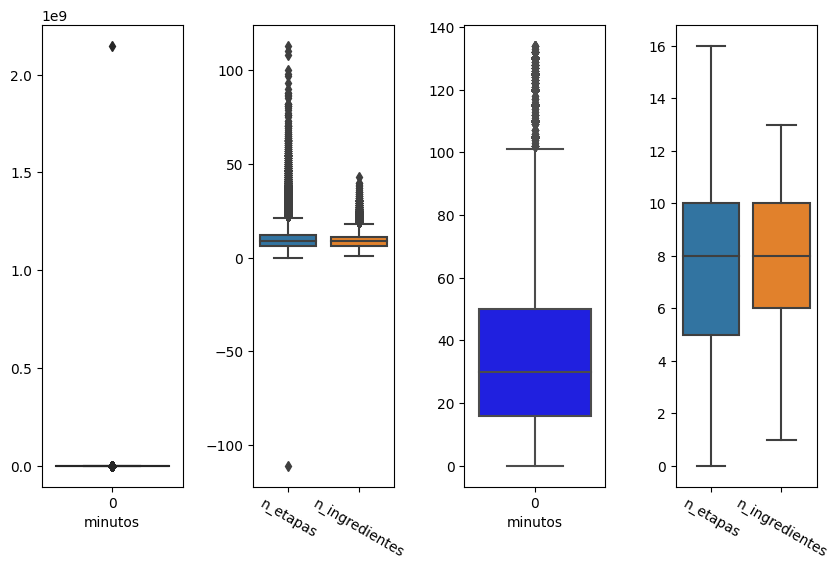

In [166]:

#sns.boxplot(df_melted,y='value',x='variable')
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
fig.subplots_adjust(wspace=0.5) 
sns.boxplot(data=df_recipes.minutos, ax=ax[0], color='green')
ax[0].set_xlabel('minutos')


f1 = sns.boxplot(data=df_recipes.loc[:,['n_etapas','n_ingredientes']], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-30)
cond1 = df_recipes.minutos<df_recipes.minutos.quantile(0.90)
cond2 = df_recipes.n_etapas<df_recipes.n_etapas.quantile(0.90)
cond3 = df_recipes.n_ingredientes<df_recipes.n_ingredientes.quantile(0.90)
df_recipes_1 = df_recipes[(cond1) & (cond2) &(cond3)]

sns.boxplot(data=df_recipes_1.minutos, ax=ax[2], color='blue')
ax[2].set_xlabel('minutos')


sns.boxplot(data=df_recipes_1.loc[:,['n_etapas','n_ingredientes']], ax=ax[3])
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=-30)

medias = df_reviews.groupby('id_receita')['avaliacao'].mean().astype('float16')
n_aval = df_reviews.groupby('id_receita')['avaliacao'].count().astype('int16')
dt = pd.merge(medias,df_recipes,right_on='id_receita',left_on='id_receita')
dt = pd.merge(n_aval,dt,right_on='id_receita',left_on='id_receita')
dt = dt.sort_values(by=['avaliacao_y','avaliacao_x'],ascending=[False,False])
dt = dt[dt.avaliacao_x>=3]
dt.plot(kind='hist',x='avaliacao_x',y='avaliacao_y')

In [142]:
# (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV) , and carbohydrates (PDV))
# O valor diário percentual (PVD) mostra o quanto um nutriente em uma porção de alimento contribui para uma dieta diária total.
""" df_recipes[df_recipes.nome.notna()]
nutricao_list = ['calorias','gordura_total','açucar','sodio','proteina','gordura_sat','carboidratos']
df_recipes[nutricao_list] = df_recipes.nutricao.str.replace('[','').str.replace(']','').str.split(',',expand=True) """
# ou se preferir alterar a ordem :
""" df_recipes['calorias'] = df_recipes.nutricao.str[0]
df_recipes['açucar'] = df_recipes.nutricao.str[2]
df_recipes['gordura_total'] = df_recipes.nutricao.str[1]
df_recipes['carboidratos'] = df_recipes.nutricao.str[6]
df_recipes['sodio'] = df_recipes.nutricao.str[3]
df_recipes['proteina'] = df_recipes.nutricao.str[4]
df_recipes['gordura_sat'] = df_recipes.nutricao.str[5]
df_recipes =  df_recipes.astype({'calorias':'float16','gordura_total':'float16','açucar':'float16','sodio':'float16','proteina':'float16','gordura_sat':'float16','carboidratos':'float16'})
df_recipes.pop('nutricao') """
#df_recipes.to_parquet('teste.parquet',engine='fastparquet')
#df_recipes

" df_recipes['calorias'] = df_recipes.nutricao.str[0]\ndf_recipes['açucar'] = df_recipes.nutricao.str[2]\ndf_recipes['gordura_total'] = df_recipes.nutricao.str[1]\ndf_recipes['carboidratos'] = df_recipes.nutricao.str[6]\ndf_recipes['sodio'] = df_recipes.nutricao.str[3]\ndf_recipes['proteina'] = df_recipes.nutricao.str[4]\ndf_recipes['gordura_sat'] = df_recipes.nutricao.str[5]\ndf_recipes =  df_recipes.astype({'calorias':'float16','gordura_total':'float16','açucar':'float16','sodio':'float16','proteina':'float16','gordura_sat':'float16','carboidratos':'float16'})\ndf_recipes.pop('nutricao') "

In [148]:
countries = ['Portugal','United States','India','China','EAT-Lancet']
plot_diet = barPlot_diet(df_diet,2017,countries)
plot_diet.show()
#py.plot(plot_diet)

In [144]:
""" chart_studio.tools.set_credentials_file(username='Mohaamedl', api_key='MvUpzt7O9SQLxrTEuefC')
cols = list(pd.read_csv(filename_diet_composition,nrows=1))
cols_diet_all =   ["País",'Code', "Ano", "cereais", "raízes_tubérculos", "legumes", "frutos", "lacticínios",
                   "carne_vermelha", "aves", "ovos", "marisco", "leguminosas", "frutos_de_casca_rija", "óleos", "açúcar"]
cols_diet_ani =  ["País", "Ano", "lacticínios",
                   "carne_vermelha", "aves", "ovos", "marisco"]
df_diet = pd.read_csv(filename_diet_composition,usecols=list(col for col in cols if  col not in [])) # por na lista o que não interessar
df_diet

df_test.columns = cols_diet_all

print(list(col for col in cols if  col not in ('Code')))



def barPlot_diet(df,year,countries=['Portugal']):
    df = df[(df['País'].isin(countries) ) & (df['Ano']==year)] # filtrar os dados por ano e paises
     Cannot convert non-finite values (NA or inf) to integer
    print(df)
    df1 = pd.melt(df, 
        id_vars='País', 
        value_vars=list(df.columns[3:-1]),
        var_name='Tipo', 
        value_name='Consumo(g)'
        ) # converte numa dataframe mais legivel para px, é como um pd.pivot reverso 
    #plot 
    fig = px.bar(df1,x='Consumo(g)',
                y='País',
                color='Tipo',
                text='Tipo',
                barmode='relative',
                title='Composisão de dieta por pais dividida por tipo de alimento'
                )
    

    fig.update_traces(textposition="inside")
    fig.update_traces(visible=True, )
    return fig

countries = ['Portugal','Spain','United States','India','China','Egypt','EAT-Lancet']
countries1 = ['Portugal','EAT-Lancet']
year = 2017
df1= df_test[(df_test['País'].isin(countries))] 
df1['Soma'] = df1.iloc[:,6:11].sum(axis=1)
df_test['Soma'] = df_test.iloc[:,6:11].sum(axis=1)
figs = px.scatter_geo(df_test, locations="Code",
                        color='País',
                        hover_name='País',
                        animation_frame='Ano',
                        size="Soma",
                        projection="natural earth")
fig = barPlot_diet(df_test,year,countries)
fig.show()
figs.show()
df1 """
#py.plot(fig) # para publicar no chart studio


' chart_studio.tools.set_credentials_file(username=\'Mohaamedl\', api_key=\'MvUpzt7O9SQLxrTEuefC\')\ncols = list(pd.read_csv(filename_diet_composition,nrows=1))\ncols_diet_all =   ["País",\'Code\', "Ano", "cereais", "raízes_tubérculos", "legumes", "frutos", "lacticínios",\n                   "carne_vermelha", "aves", "ovos", "marisco", "leguminosas", "frutos_de_casca_rija", "óleos", "açúcar"]\ncols_diet_ani =  ["País", "Ano", "lacticínios",\n                   "carne_vermelha", "aves", "ovos", "marisco"]\ndf_diet = pd.read_csv(filename_diet_composition,usecols=list(col for col in cols if  col not in [])) # por na lista o que não interessar\ndf_diet\n\ndf_test.columns = cols_diet_all\n\nprint(list(col for col in cols if  col not in (\'Code\')))\n\n\n\ndef barPlot_diet(df,year,countries=[\'Portugal\']):\n    df = df[(df[\'País\'].isin(countries) ) & (df[\'Ano\']==year)] # filtrar os dados por ano e paises\n     Cannot convert non-finite values (NA or inf) to integer\n    print(df)\n    d